# Part 0 - Preliminaries

## Install Libraries

In [1]:
#%pip install category_encoders

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,  MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import sys
import os
import warnings

warnings.filterwarnings("ignore")

# Apply Seaborn's aesthetic parameters to match Matplotlib's style
sns.set()

pd.set_option('display.max_columns', None)

FILE_NAME = "2016_Building_Energy_Benchmarking_Clean.csv.bz2"
TARGET_COLUMN = 'TotalGHGEmissions'
DROP_COLUMN = 'SiteEnergyUse(kBtu)'
STAR_COLUMN = 'ENERGYSTARScore'

# Load Data

In [3]:
df = pd.read_csv(FILE_NAME)
df["ListOfAllPropertyUseTypes"] = MinMaxScaler((1,2)).fit_transform(df["ListOfAllPropertyUseTypes"].values.reshape(-1, 1))
print(f"Rows - {df.shape[0]}\nColumns - {df.shape[1]}")
df.head()

Rows - 2524
Columns - 30


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,No.PropertyTypes,AgeOfBuilding,EnergyEfficiency
0,4,3,1.0,5,1.0,0.046452,0.039249,0.999665,0.457981,1.0,6,0.395155,16,0.986641,15,1.000000,1.0,0.440571,0.101031,0.072881,0.016116,0.014850,0.014788,0.004285,0,1.0,0.014864,1.000000,0.0,0.485938
1,4,3,1.0,5,1.0,0.055760,0.047049,0.146640,0.457240,1.0,6,0.443430,26,0.424961,32,0.332309,1.0,0.453725,0.117330,0.069219,0.018707,0.000000,0.012228,0.017271,0,1.0,0.017583,0.138177,0.0,0.626964
2,4,3,1.0,5,1.0,0.005194,0.486522,0.003123,0.001629,1.0,6,0.003747,16,0.986641,15,1.000000,1.0,0.177116,0.117090,0.093894,0.161885,0.159819,0.180748,0.005014,0,1.0,0.123880,1.000000,0.0,0.381817
3,4,3,1.0,5,1.0,0.066849,0.025272,0.999665,0.819007,1.0,6,0.758605,16,0.986641,15,1.000000,1.0,0.385181,0.135786,0.086229,0.015153,0.016410,0.010502,0.006080,0,1.0,0.017024,1.000000,0.0,0.656127
4,4,3,1.0,5,1.0,0.015119,0.084171,0.009942,0.261571,1.0,6,0.184859,26,0.026488,37,1.000000,1.0,0.699382,0.142258,0.083025,0.031608,0.000000,0.019967,0.029553,0,1.0,0.029980,0.138177,0.0,0.588326


# Recursive Feature Selection

Apply standard linear or non-linear models to determine the best features and models to act as a base line.

In [4]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 
    
def get_models(model_types):
    """Return a list of models based on the model type."""
    if model_types == "linear":
        return [LinearRegression(), LinearSVR(dual="auto"), Ridge(), Lasso(), ElasticNet()]
    elif model_types == "non-linear":
        return [DecisionTreeRegressor(), RandomForestRegressor(random_state=42),
                GradientBoostingRegressor(random_state=42), ExtraTreeRegressor(random_state=42)]
    else:
        raise ValueError("Invalid model_types value. Choose 'linear' or 'non-linear'.")

def feature_selection_and_evaluation(X_train, y_train, X_test, y_test, model):
    """Apply RFECV for feature selection and evaluate the model."""
    selector = RFECV(estimator=model, step=1, cv=5, scoring='r2', n_jobs=-1)
    selector.fit(X_train, y_train)
    
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    r2 = r2_score(y_test, y_pred)
    
    return r2, selector.support_

def best_features_via_rfecv(df, target_col, model_types):
    """
    Function to find the best features using RFECV and return the best model
    based on R2 score.
    """
    # Splitting the dataframe into features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Splitting into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    models = get_models(model_types)
    
    best_r2 = -np.inf  # Initialize with negative infinity as we aim to maximize R2
    best_features = None
    best_model = None
    
    for model in models:
        r2, feature_mask = feature_selection_and_evaluation(X_train, y_train, X_test, y_test, model)
        
        if r2 > best_r2:
            best_r2 = r2
            best_features = X.columns[feature_mask].tolist()
            best_model = model

    return best_features, best_model, best_r2


# DataFrames


In [5]:
#df1 = df.drop(columns=['SiteEnergyUse(kBtu)', 'ENERGYSTARScore']).dropna().copy()
#df2 = df.drop(columns=['SiteEnergyUse(kBtu)']).dropna().copy()

# Without Energy Star Score
df1 = df.drop(columns=[DROP_COLUMN, STAR_COLUMN]).dropna().copy()
# With Energy Star Score
df2 = df.drop(columns=[DROP_COLUMN]).dropna().copy()

# Apply RFECV

In [6]:
# Linear Models
best_cols_linear_v1, best_linear_model_v1, best_linear_r2_v1  = best_features_via_rfecv(df1, TARGET_COLUMN, "linear")
print(f"Best Model: {best_linear_model_v1}, Best R2 Score: {best_linear_r2_v1}, Best Features: {best_cols_linear_v1}")
best_cols_linear_v2, best_linear_model_v2, best_linear_r2_v2 = best_features_via_rfecv(df2, TARGET_COLUMN, "linear")
print(f"Best Model: {best_linear_model_v2}, Best R2 Score: {best_linear_r2_v2}, Best Features: {best_cols_linear_v2}")

# Non-Linear Models
best_cols_nonlinear_v1, best_nonlinear_model_v1, best_nonlinear_r2_v1 = best_features_via_rfecv(df1, TARGET_COLUMN, "non-linear")
print(f"Best Model: {best_nonlinear_model_v1}, Best R2 Score: {best_nonlinear_r2_v1}, Best Features: {best_cols_nonlinear_v1}")
best_cols_nonlinear_v2, best_nonlinear_model_v2, best_nonlinear_r2_v2 = best_features_via_rfecv(df2, TARGET_COLUMN, "non-linear")
print(f"Best Model: {best_nonlinear_model_v2}, Best R2 Score: {best_nonlinear_r2_v2}, Best Features: {best_cols_nonlinear_v2}")

Best Model: LinearRegression(), Best R2 Score: 0.9999999999026072, Best Features: ['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'ThirdLargestPropertyUseTypeGFA', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Outlier', 'No.PropertyTypes']
Best Model: LinearRegression(), Best R2 Score: 0.9999999999024444, Best Features: ['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Outlier', 'No.PropertyTypes']
Best Model: DecisionTreeRegressor(), Best R2 Score: 0.02775786352801879, Best Features: ['PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTyp

# Selected Variables

In [7]:
print(f"Total Variables - {len(df.columns.tolist())}")
df_vars = pd.DataFrame([best_cols_linear_v1, best_cols_linear_v2, best_cols_nonlinear_v1, best_cols_nonlinear_v2]).T
df_vars.columns = ["Linear - Without Energy Star Score", "Linear - With Energy Star Score", "Non-Linear - Without Energy Star Score", "Non-Linear - With Energy Star Score"]
df_vars

Total Variables - 30


,Linear - Without Energy Star Score,Linear - With Energy Star Score,Non-Linear - Without Energy Star Score,Non-Linear - With Energy Star Score
0,CouncilDistrictCode,CouncilDistrictCode,PrimaryPropertyType,PrimaryPropertyType
1,NumberofBuildings,NumberofBuildings,CouncilDistrictCode,Neighborhood
2,NumberofFloors,NumberofFloors,Neighborhood,NumberofFloors
3,PropertyGFATotal,PropertyGFATotal,NumberofFloors,PropertyGFATotal
4,PropertyGFABuilding(s),PropertyGFABuilding(s),PropertyGFATotal,PropertyGFABuilding(s)
5,ThirdLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,PropertyGFAParking,LargestPropertyUseType
6,SiteEUIWN(kBtu/sf),ENERGYSTARScore,PropertyGFABuilding(s),LargestPropertyUseTypeGFA
7,SourceEUIWN(kBtu/sf),SiteEUIWN(kBtu/sf),LargestPropertyUseTypeGFA,SecondLargestPropertyUseType
8,SteamUse(kBtu),SourceEUIWN(kBtu/sf),SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA
9,Electricity(kBtu),SteamUse(kBtu),SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA


# Base Line performance

In [8]:
# List of models and feature sets
models_and_features = [
    (best_cols_linear_v1, best_linear_model_v1), 
    (best_cols_linear_v2, best_linear_model_v2), 
    (best_cols_nonlinear_v1, best_nonlinear_model_v1), 
    (best_cols_nonlinear_v2, best_nonlinear_model_v2)
]

# Initialize DummyRegressor
dummy_model = DummyRegressor(strategy="mean")

# Loop through feature sets for DummyRegressor
for best_cols in [best_cols_linear_v1, best_cols_linear_v2, best_cols_nonlinear_v1, best_cols_nonlinear_v2]:
    models_and_features.append((best_cols, dummy_model))

# Loop through models and feature sets
for best_cols, model in models_and_features:
    
    # Splitting the data
    X = df[best_cols]
    y = df[TARGET_COLUMN]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)
    
    # Get the score
    score = model.score(X_test, y_test)
    
    # Print results
    print(f"Model: {type(model).__name__}")
    print(f"Hyperparameters: {model.get_params()}")
    print(f"Features Used: {best_cols}")
    print(f"Test Score (R2): {score:.4f}")
    print("=" * 40)

Model: LinearRegression
Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Features Used: ['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'ThirdLargestPropertyUseTypeGFA', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Outlier', 'No.PropertyTypes']
Test Score (R2): 1.0000
Model: LinearRegression
Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Features Used: ['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Outlier', 'No.PropertyTypes']
Test Score (R2): 1.0000


Model: DecisionTreeRegressor
Hyperparameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Features Used: ['PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'EnergyEfficiency']
Test Score (R2): -2.7453
Model: DecisionTreeRegressor
Hyperparameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 

# Grid Search

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def perform_grid_search(df, target_col, best_model, best_features):
    """
    Perform Grid Search on the best model using the best features.
    """
    # Select only the best features and target column from the DataFrame
    X = df[best_features]
    y = df[target_col]
    
    # Splitting into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define hyperparameter grid based on the model type
    param_grid = {}
    if isinstance(best_model, LinearRegression):
        param_grid = {'fit_intercept': [True, False]}
    elif isinstance(best_model, LinearSVR):
        param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}
    elif isinstance(best_model, Ridge):
        param_grid = {'alpha': [0.01, 0.1, 1, 10], 'fit_intercept': [True, False], 'normalize': [True, False]}
    elif isinstance(best_model, Lasso):
        param_grid = {'alpha': [0.01, 0.1, 1, 10]}
    elif isinstance(best_model, ElasticNet):
        param_grid = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
    elif isinstance(best_model, DecisionTreeRegressor):
        param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    elif isinstance(best_model, RandomForestRegressor):
        param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    elif isinstance(best_model, GradientBoostingRegressor):
        param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 8]}
    elif isinstance(best_model, ExtraTreeRegressor):
        param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    else:
        raise ValueError(f"Grid search not implemented for {type(best_model)}")
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid,
                               scoring=make_scorer(r2_score), cv=5, n_jobs=-1)
    
    # Fit the model on the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and best model
    best_params = grid_search.best_params_
    best_grid_model = grid_search.best_estimator_
    
    # Evaluate the model on the test data
    y_pred = best_grid_model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    
    return best_params, best_grid_model, test_r2

In [10]:
# Define a list of tuples containing information for each model version
# Each tuple contains: (best_params_str, best_grid_str, test_r2_str, best_model, best_features)
model_versions = [
    ('best_params_linear_model_v1', 'best_grid_linear_model_v1', 'test_r2_linear_model_v1', best_linear_model_v1, best_cols_linear_v1),
    ('best_params_linear_model_v2', 'best_grid_linear_model_v2', 'test_r2_linear_model_v2', best_linear_model_v2, best_cols_linear_v2),
    ('best_params_nonlinear_model_v1', 'best_grid_nonlinear_model_v1', 'test_r2_nonlinear_model_v1', best_nonlinear_model_v1, best_cols_nonlinear_v1),
    ('best_params_nonlinear_model_v2', 'best_grid_nonlinear_model_v2', 'test_r2_nonlinear_model_v2', best_nonlinear_model_v2, best_cols_nonlinear_v2),
]

# Iterate through each model version to perform grid search
for best_params_str, best_grid_str, test_r2_str, best_model, best_features in model_versions:
    # Perform grid search and unpack the returned tuple
    best_params, best_grid, test_r2 = perform_grid_search(
        df=df, 
        target_col=TARGET_COLUMN, 
        best_model=best_model, 
        best_features=best_features
    )
    # Dynamically create variables to store these results
    globals()[best_params_str] = best_params
    globals()[best_grid_str] = best_grid
    globals()[test_r2_str] = test_r2


In [11]:
# Function to print the results in a formatted way
def print_results(model_name, best_params, best_grid_model, test_r2):
    print(f"{'='*50}")
    print(f"Results for {model_name}")
    print(f"{'-'*50}")
    print(f"Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    print(f"\nBest Grid Model:")
    print(f"  {best_grid_model}")
    print(f"\nTest R2 Score: {test_r2:.4f}")
    print(f"{'='*50}\n")

# Print the results for each model
print_results("Linear Model V1", best_params_linear_model_v1, best_grid_linear_model_v1, test_r2_linear_model_v1)
print_results("Linear Model V2", best_params_linear_model_v2, best_grid_linear_model_v2, test_r2_linear_model_v2)
print_results("Non-Linear Model V1", best_params_nonlinear_model_v1, best_grid_nonlinear_model_v1, test_r2_nonlinear_model_v1)
print_results("Non-Linear Model V2", best_params_nonlinear_model_v2, best_grid_nonlinear_model_v2, test_r2_nonlinear_model_v2)

Results for Linear Model V1
--------------------------------------------------
Best Hyperparameters:
  fit_intercept: True

Best Grid Model:
  LinearRegression()

Test R2 Score: 1.0000

Results for Linear Model V2
--------------------------------------------------
Best Hyperparameters:
  fit_intercept: True

Best Grid Model:
  LinearRegression()

Test R2 Score: 1.0000

Results for Non-Linear Model V1
--------------------------------------------------
Best Hyperparameters:
  max_depth: 30
  min_samples_split: 2

Best Grid Model:
  DecisionTreeRegressor(max_depth=30)

Test R2 Score: -2.8285

Results for Non-Linear Model V2
--------------------------------------------------
Best Hyperparameters:
  max_depth: None
  min_samples_split: 5

Best Grid Model:
  DecisionTreeRegressor(min_samples_split=5)

Test R2 Score: -0.9273



In [12]:
def get_feature_importance(best_model, best_features, plot=True):
    """
    Get feature importance based on the type of the best model.
    Optionally, generate a bar plot for the feature importances.
    """
    if isinstance(best_model, (DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor, ExtraTreeRegressor)):
        # For tree-based models
        feature_importance = best_model.feature_importances_
    elif isinstance(best_model, (LinearRegression, Ridge, Lasso, ElasticNet)):
        # For linear models
        feature_importance = best_model.coef_
    elif isinstance(best_model, LinearSVR):
        # For LinearSVR
        feature_importance = best_model.coef_
    else:
        raise ValueError(f"Feature importance extraction not implemented for {type(best_model)}")
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': best_features,
        'Importance': feature_importance
    })
    
    # Sort by absolute value of importance
    feature_importance_df['Abs_Importance'] = feature_importance_df['Importance'].apply(abs)
    feature_importance_df = feature_importance_df.sort_values(by='Abs_Importance', ascending=False).drop('Abs_Importance', axis=1)
    
    if plot:
        # Generate the bar plot
        plt.figure(figsize=(12, 8))
        plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('Feature Importance')
        plt.show()
    
    return feature_importance_df

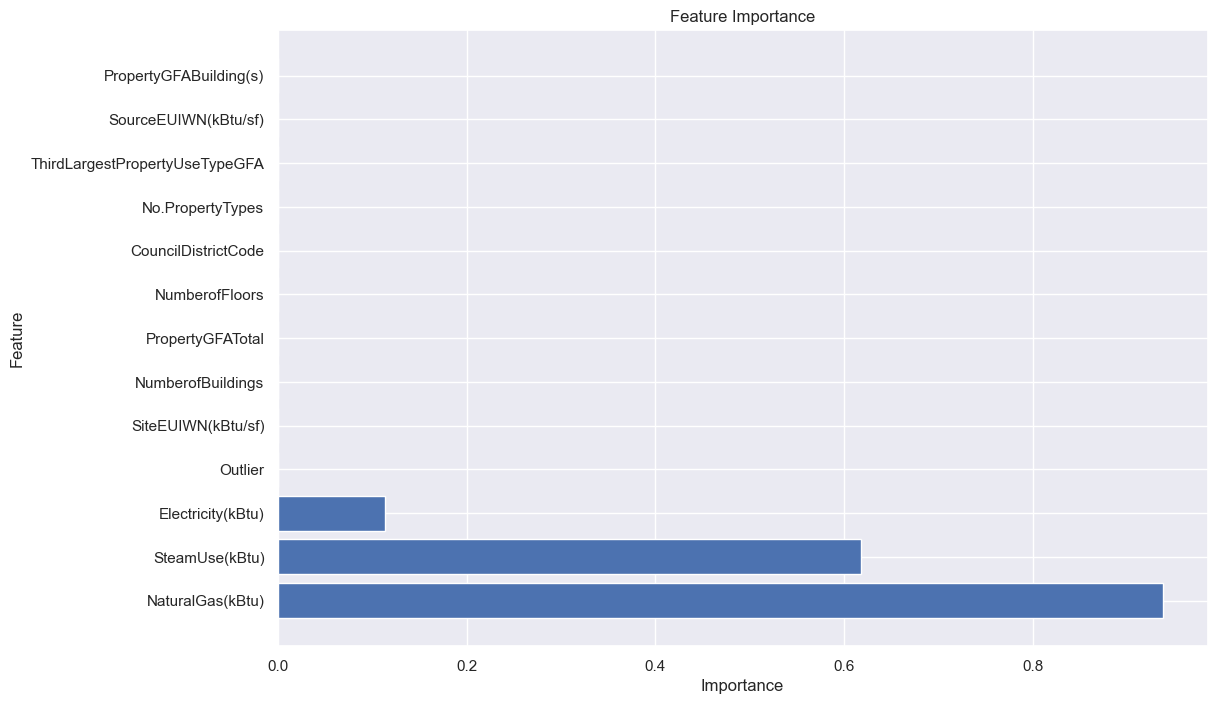

Feature Importance for best_linear_model_v1:
                           Feature    Importance
10                NaturalGas(kBtu)  9.377760e-01
8                   SteamUse(kBtu)  6.173623e-01
9                Electricity(kBtu)  1.134843e-01
11                         Outlier  9.333034e-08
6               SiteEUIWN(kBtu/sf) -8.437982e-08
1                NumberofBuildings  4.704632e-08
3                 PropertyGFATotal -3.238233e-08
2                   NumberofFloors -3.128230e-08
0              CouncilDistrictCode -3.033844e-08
12                No.PropertyTypes -2.849596e-08
5   ThirdLargestPropertyUseTypeGFA  2.767397e-08
7             SourceEUIWN(kBtu/sf) -2.537039e-08
4           PropertyGFABuilding(s)  1.728499e-08


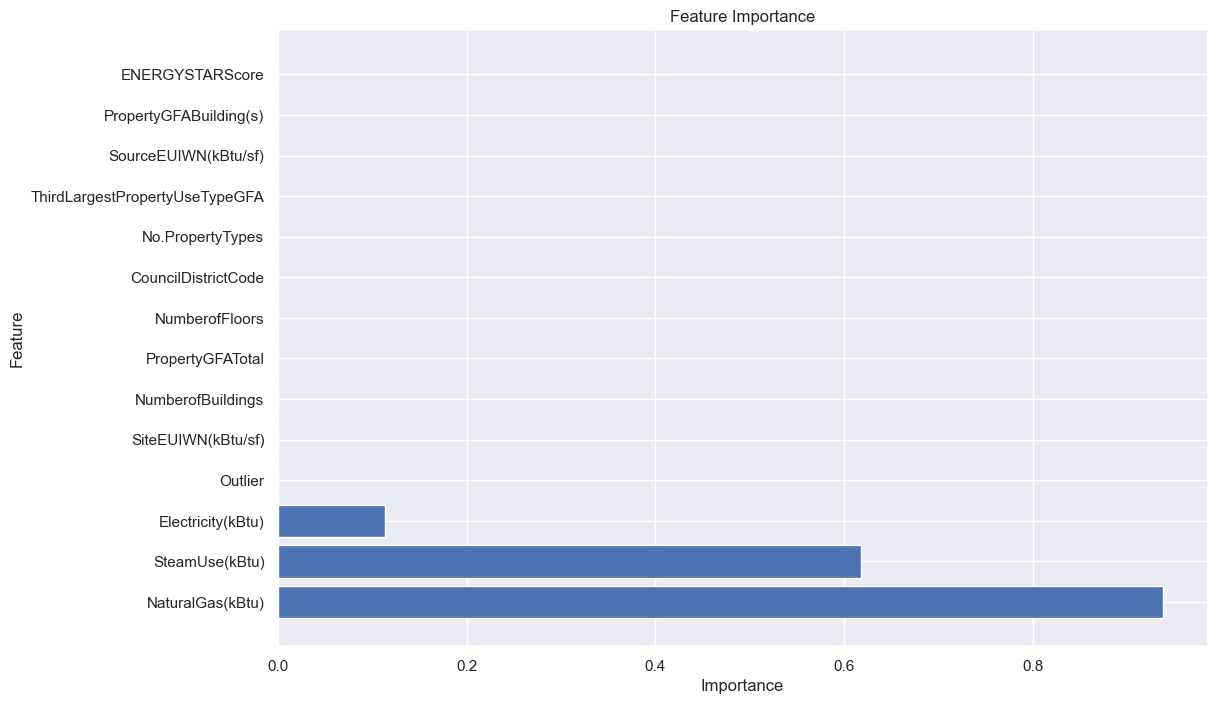

Feature Importance for best_linear_model_v2:
                           Feature    Importance
11                NaturalGas(kBtu)  9.377760e-01
9                   SteamUse(kBtu)  6.173623e-01
10               Electricity(kBtu)  1.134843e-01
12                         Outlier  9.251206e-08
7               SiteEUIWN(kBtu/sf) -5.590415e-08
1                NumberofBuildings  4.678929e-08
3                 PropertyGFATotal -3.569151e-08
2                   NumberofFloors -3.217532e-08
0              CouncilDistrictCode -3.112292e-08
13                No.PropertyTypes -2.704020e-08
5   ThirdLargestPropertyUseTypeGFA  2.682845e-08
8             SourceEUIWN(kBtu/sf) -2.381155e-08
4           PropertyGFABuilding(s)  1.802358e-08
6                  ENERGYSTARScore  1.564080e-08


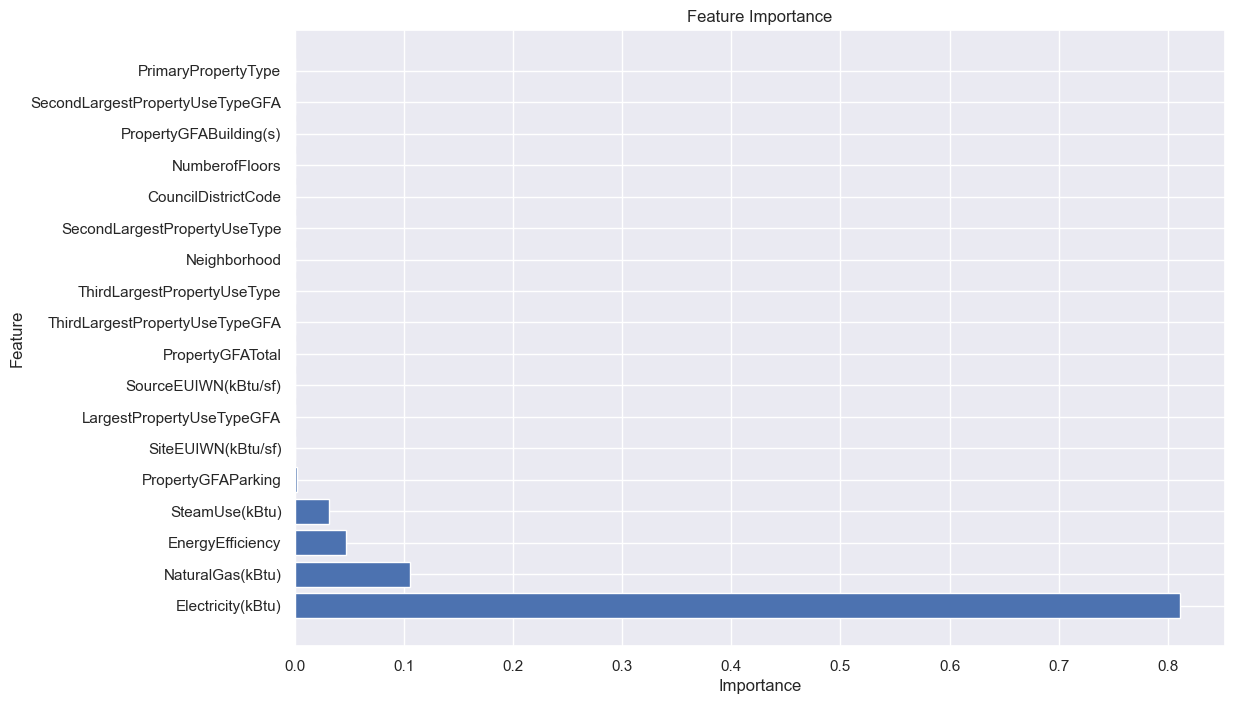

Feature Importance for best_nonlinear_model_v1:
                            Feature  Importance
15                Electricity(kBtu)    0.811408
16                 NaturalGas(kBtu)    0.106063
17                 EnergyEfficiency    0.047418
14                   SteamUse(kBtu)    0.031561
5                PropertyGFAParking    0.002531
12               SiteEUIWN(kBtu/sf)    0.000477
7         LargestPropertyUseTypeGFA    0.000308
13             SourceEUIWN(kBtu/sf)    0.000082
4                  PropertyGFATotal    0.000072
11   ThirdLargestPropertyUseTypeGFA    0.000051
10      ThirdLargestPropertyUseType    0.000014
2                      Neighborhood    0.000005
8      SecondLargestPropertyUseType    0.000003
1               CouncilDistrictCode    0.000002
3                    NumberofFloors    0.000002
6            PropertyGFABuilding(s)    0.000002
9   SecondLargestPropertyUseTypeGFA    0.000002
0               PrimaryPropertyType    0.000001


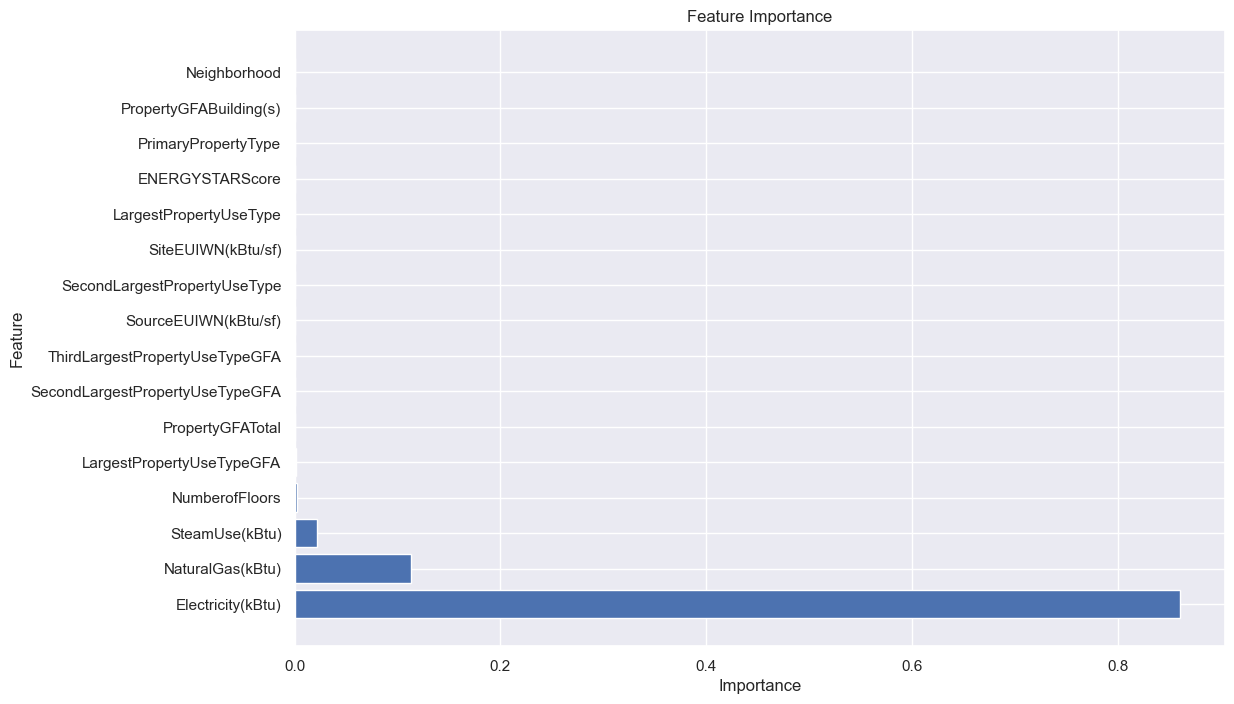

Feature Importance for best_nonlinear_model_v2:
                            Feature    Importance
14                Electricity(kBtu)  8.608224e-01
15                 NaturalGas(kBtu)  1.127847e-01
13                   SteamUse(kBtu)  2.204941e-02
2                    NumberofFloors  2.701564e-03
6         LargestPropertyUseTypeGFA  1.424978e-03
3                  PropertyGFATotal  7.540713e-05
8   SecondLargestPropertyUseTypeGFA  5.263352e-05
9    ThirdLargestPropertyUseTypeGFA  5.078087e-05
12             SourceEUIWN(kBtu/sf)  2.769205e-05
7      SecondLargestPropertyUseType  3.091852e-06
11               SiteEUIWN(kBtu/sf)  2.285914e-06
5            LargestPropertyUseType  1.664265e-06
10                  ENERGYSTARScore  1.012274e-06
0               PrimaryPropertyType  1.002019e-06
4            PropertyGFABuilding(s)  8.679065e-07
1                      Neighborhood  4.943211e-07


In [13]:
# For best_linear_model_v1
feature_importance_df_linear_v1 = get_feature_importance(best_model=best_grid_linear_model_v1, 
                                                         best_features=best_cols_linear_v1,
                                                         plot=True)
print("Feature Importance for best_linear_model_v1:")
print(feature_importance_df_linear_v1)

# For best_linear_model_v2
feature_importance_df_linear_v2 = get_feature_importance(best_model=best_grid_linear_model_v2, 
                                                         best_features=best_cols_linear_v2,
                                                         plot=True)
print("Feature Importance for best_linear_model_v2:")
print(feature_importance_df_linear_v2)

# For best_nonlinear_model_v1
feature_importance_df_nonlinear_v1 = get_feature_importance(best_model=best_grid_nonlinear_model_v1, 
                                                            best_features=best_cols_nonlinear_v1,
                                                            plot=True)
print("Feature Importance for best_nonlinear_model_v1:")
print(feature_importance_df_nonlinear_v1)

# For best_nonlinear_model_v2
feature_importance_df_nonlinear_v2 = get_feature_importance(best_model=best_grid_nonlinear_model_v2, 
                                                            best_features=best_cols_nonlinear_v2,
                                                            plot=True)
print("Feature Importance for best_nonlinear_model_v2:")
print(feature_importance_df_nonlinear_v2)
